In [78]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import lightgbm as lgb  
import torch 
import tensorflow as tf 
import torch.nn as nn
from neuralprophet import NeuralProphet

In [18]:
ss = pd.read_csv("sample_submission.csv") 
ss.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [76]:
ss.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [85]:
ss.iloc[:2161]

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0
...,...,...
2156,2019-03-31 21 A,0
2157,2019-03-31 22 A,0
2158,2019-03-31 23 A,0
2159,2019-03-31 24 A,0


In [21]:
test = pd.read_csv("test.csv") 

test

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A
...,...
15115,2019-03-31 20 H
15116,2019-03-31 21 H
15117,2019-03-31 22 H
15118,2019-03-31 23 H


In [72]:
test['일자'] = test['일자|시간|구분'].str.split().str[0]

In [73]:
test['시간'] = test['일자|시간|구분'].str.split().str[1]

In [74]:
test['구분'] = test['일자|시간|구분'].str.split().str[2] 


test

,일자|시간|구분,일자,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H
15116,2019-03-31 21 H,2019-03-31,21,H
15117,2019-03-31 22 H,2019-03-31,22,H
15118,2019-03-31 23 H,2019-03-31,23,H


In [75]:
test[test['구분']=='A']

,일자|시간|구분,일자,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A
...,...,...,...,...
2155,2019-03-31 20 A,2019-03-31,20,A
2156,2019-03-31 21 A,2019-03-31,21,A
2157,2019-03-31 22 A,2019-03-31,22,A
2158,2019-03-31 23 A,2019-03-31,23,A


This shows that we have to predict the next 2160 timesteps

In [23]:
total = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding='cp949') 

total

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


In [24]:
total['구분'].unique() 

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [25]:
total.shape

(368088, 4)

In [26]:
d_map = {} 
for i,d in enumerate(total['구분'].unique()): 
    d_map[d] = i 

total['구분'] = total['구분'].map(d_map)

In [27]:
total['연월일'] = pd.to_datetime(total['연월일']) 

In [28]:
total['year'] = total['연월일'].dt.year  
total['month'] = total['연월일'].dt.month 
total['day'] = total['연월일'].dt.day 
total['weekday'] = total['연월일'].dt.weekday 

total

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0
368084,2018-12-31,21,6,669.961,2018,12,31,0
368085,2018-12-31,22,6,657.941,2018,12,31,0
368086,2018-12-31,23,6,610.953,2018,12,31,0


# Inspect Data

In [65]:
type0 = total[total['구분']==0] 


In [66]:
type0

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
315523,2018-12-31,20,0,3040.868,2018,12,31,0
315524,2018-12-31,21,0,2973.577,2018,12,31,0
315525,2018-12-31,22,0,2840.272,2018,12,31,0
315526,2018-12-31,23,0,2692.385,2018,12,31,0


In [67]:
type0 = total[total['구분']==0] 

type0_supplies = type0['공급량'].values 

type0_supplies

array([2497.129, 2363.265, 2258.505, ..., 2840.272, 2692.385, 2583.34 ])

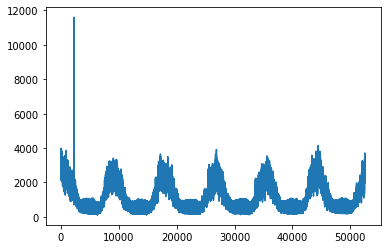

In [68]:
plt.plot(type0_supplies)

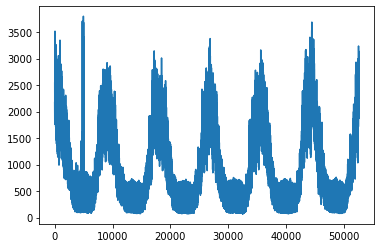

In [31]:
type1 = total[total['구분']==1] 
type1_supplies = type1['공급량'].values 
plt.plot(type1_supplies)

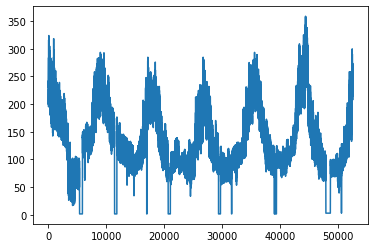

In [32]:
type2 = total[total['구분']==2] 
type2_supplies = type2['공급량'].values 
plt.plot(type2_supplies)

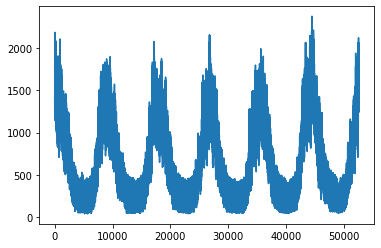

In [33]:
type3 = total[total['구분']==3]
type3_supplies = type3['공급량'].values 
plt.plot(type3_supplies)

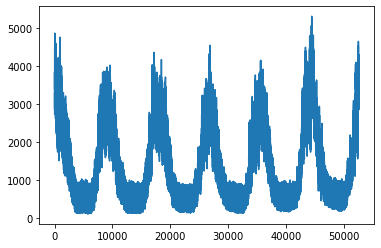

In [34]:
type4 = total[total['구분']==4] 
type4_supplies = type4['공급량'].values  
plt.plot(type4_supplies)

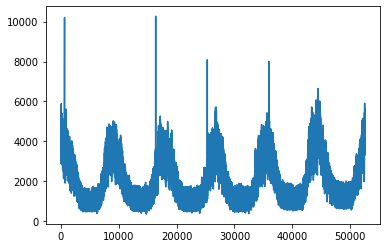

In [36]:
type5 = total[total['구분']==5] 
type5_supplies = type5['공급량'].values 
plt.plot(type5_supplies)

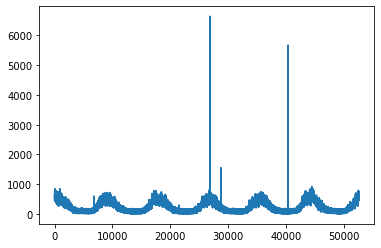

In [37]:
type6 = total[total['구분']==6] 
type6_supplies = type6['공급량'].values  
plt.plot(type6_supplies) 

# Try Neural Prophet 

Supplier 0

In [71]:
df0 = total[total['구분']==0] 

df0['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df0['y'] = df0['공급량']

df0 = df0[['ds','y']] 
df0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ds,y
0,2013-01-01 00:00:00,2497.129
1,2013-01-01 01:00:00,2363.265
2,2013-01-01 02:00:00,2258.505
3,2013-01-01 03:00:00,2243.969
4,2013-01-01 04:00:00,2344.105
...,...,...
315523,2018-12-31 19:00:00,3040.868
315524,2018-12-31 20:00:00,2973.577
315525,2018-12-31 21:00:00,2840.272
315526,2018-12-31 22:00:00,2692.385


In [79]:
model0 = NeuralProphet() 
model0.fit(df0, freq="H")

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 67


  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.84E-02, min: 1.16E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.38E-01
Epoch[67/67]: 100%|██████████| 67/67 [02:35<00:00,  2.33s/it, SmoothL1Loss=0.00447, MAE=174, MSE=5.67e+4, RegLoss=0]


NameError: name 'model' is not defined

In [80]:
fut = model0.make_future_dataframe(df0, periods=2160)
forecast = model0.predict(fut) 


In [81]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2019-01-01 00:00:00,None,2136.023438,None,1173.443848,1103.462036,60.786530,-201.668930
1,2019-01-01 01:00:00,None,1975.190796,None,1173.435547,1103.621704,60.585293,-362.451843
2,2019-01-01 02:00:00,None,1907.576904,None,1173.427002,1103.781006,60.111919,-429.743073
3,2019-01-01 03:00:00,None,1935.154053,None,1173.418579,1103.940186,59.395889,-401.600616
4,2019-01-01 04:00:00,None,2009.003906,None,1173.410156,1104.098633,58.467552,-326.972443
...,...,...,...,...,...,...,...,...
2155,2019-03-31 19:00:00,None,1271.820068,None,1155.246216,-28.251411,-88.366684,233.192017
2156,2019-03-31 20:00:00,None,1224.720825,None,1155.237671,-28.913879,-80.607178,179.004166
2157,2019-03-31 21:00:00,None,1146.911377,None,1155.229248,-29.575808,-72.683044,93.940941
2158,2019-03-31 22:00:00,None,1095.782349,None,1155.220825,-30.237272,-64.645195,35.444057


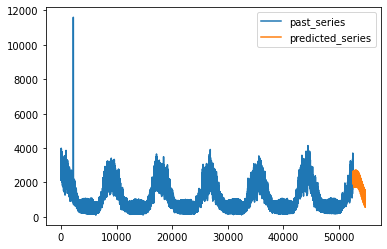

In [87]:
yhat0 = forecast['yhat1'].values 
past_seq = type0['공급량'].values  

plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat0)), yhat0, label='predicted_series')
plt.legend()

## Supplier 1

In [88]:
df1 = total[total['구분']==1] 

df1['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df1['y'] = df1['공급량']

df1 = df1[['ds','y']] 
model1 = NeuralProphet() 
model1.fit(df1, freq="H")
fut1 = model1.make_future_dataframe(df1, periods=2160)
forecast1 = model1.predict(fut1) 


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto

  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.22E-02, min: 1.40E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.52E-01
Epoch[67/67]: 100%|██████████| 67/67 [02:41<00:00,  2.41s/it, SmoothL1Loss=0.0047, MAE=159, MSE=4.59e+4, RegLoss=0] 


KeyError: '공급량'

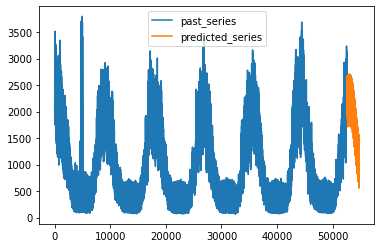

In [89]:
yhat1 = forecast1['yhat1'].values 
past_seq = type1['공급량'].values 

## plot ##
plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat0)), yhat0, label='predicted_series')
plt.legend()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto

  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.42E-02, min: 1.16E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.59E-01
Epoch[67/67]: 100%|██████████| 67/67 [02:31<00:00,  2.27s/it, SmoothL1Loss=0.00726, MAE=19.4, MSE=797, RegLoss=0]    


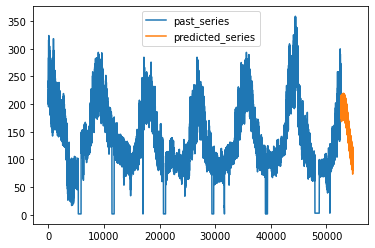

In [91]:
df2 = total[total['구분']==2] 

df2['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df2['y'] = df2['공급량']

df2 = df2[['ds','y']] 
model2 = NeuralProphet() 
model2.fit(df2, freq="H")
fut2 = model2.make_future_dataframe(df2, periods=2160)
forecast2 = model2.predict(fut2) 
yhat2 = forecast2['yhat1'].values 
past_seq = type2['공급량'].values 

## plot ##
plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat2)), yhat2, label='predicted_series')
plt.legend()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto

  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.38E-02, min: 1.69E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.99E-01
Epoch[67/67]: 100%|██████████| 67/67 [02:51<00:00,  2.56s/it, SmoothL1Loss=0.00391, MAE=98.5, MSE=1.72e+4, RegLoss=0]


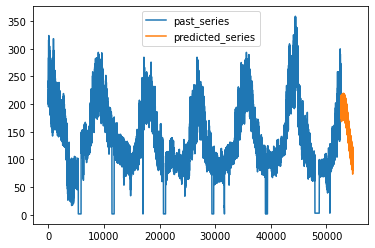

In [92]:
df3 = total[total['구분']==3] 

df3['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df3['y'] = df3['공급량']

df3 = df3[['ds','y']] 
model3 = NeuralProphet() 
model3.fit(df3, freq="H")
fut3 = model3.make_future_dataframe(df3, periods=2160)
forecast3 = model3.predict(fut3) 
yhat3 = forecast3['yhat1'].values 
past_seq = type2['공급량'].values 

## plot ##
plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat2)), yhat2, label='predicted_series')
plt.legend()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto

  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 1.32E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.70E-01
Epoch[67/67]: 100%|██████████| 67/67 [02:37<00:00,  2.35s/it, SmoothL1Loss=0.00431, MAE=217, MSE=8.59e+4, RegLoss=0]   


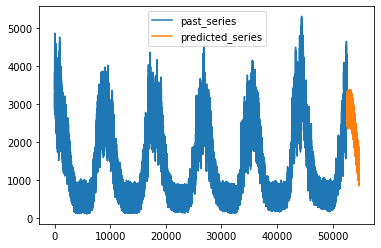

In [93]:
df4 = total[total['구분']==4] 

df4['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df4['y'] = df4['공급량']

df4 = df4[['ds','y']] 
model4 = NeuralProphet() 
model4.fit(df4, freq="H")
fut4 = model4.make_future_dataframe(df4, periods=2160)
forecast4 = model4.predict(fut4) 
yhat4 = forecast4['yhat1'].values 
past_seq = type4['공급량'].values 

## plot ##
plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat4)), yhat4, label='predicted_series')
plt.legend()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto

  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.02E-02, min: 1.16E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.45E-01
Epoch[67/67]: 100%|██████████| 67/67 [02:41<00:00,  2.41s/it, SmoothL1Loss=0.00433, MAE=255, MSE=1.22e+5, RegLoss=0]   


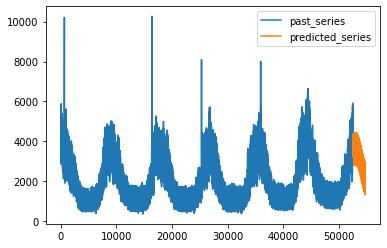

In [94]:
df5 = total[total['구분']==5] 

df5['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df5['y'] = df5['공급량']

df5 = df5[['ds','y']] 
model5 = NeuralProphet() 
model5.fit(df5, freq="H")
fut5 = model5.make_future_dataframe(df5, periods=2160)
forecast5 = model5.predict(fut5) 
yhat5 = forecast5['yhat1'].values 
past_seq = type5['공급량'].values 

## plot ##
plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat5)), yhat5, label='predicted_series')
plt.legend()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto

  0%|          | 0/336 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.02E-02, min: 1.16E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.45E-01
Epoch[67/67]: 100%|██████████| 67/67 [03:00<00:00,  2.69s/it, SmoothL1Loss=0.00456, MAE=39.3, MSE=4.33e+3, RegLoss=0]


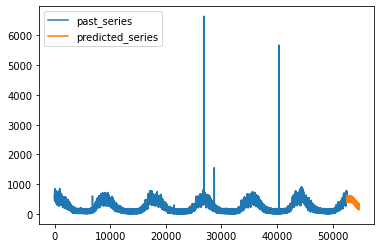

In [95]:
df6 = total[total['구분']==6] 

df6['ds'] = pd.date_range(start='1/1/2013', end='1/1/2019', freq='H')[:-1]
df6['y'] = df6['공급량']

df6 = df6[['ds','y']] 
model6 = NeuralProphet() 
model6.fit(df6, freq="H")
fut6 = model6.make_future_dataframe(df6, periods=2160)
forecast6 = model6.predict(fut6) 
yhat6 = forecast6['yhat1'].values 
past_seq = type6['공급량'].values 

## plot ##
plt.plot(past_seq, label='past_series') 
plt.plot(np.arange(len(past_seq),len(past_seq)+len(yhat6)), yhat6, label='predicted_series')
plt.legend()

In [97]:
full_predictions = np.concatenate([yhat0,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6])

full_predictions.shape

(15120,)

In [98]:
ss.shape

(15120, 2)

In [100]:
ss['공급량'] = full_predictions 

ss

,일자|시간|구분,공급량
0,2019-01-01 01 A,2136.023438
1,2019-01-01 02 A,1975.190796
2,2019-01-01 03 A,1907.576904
3,2019-01-01 04 A,1935.154053
4,2019-01-01 05 A,2009.003906
...,...,...
15115,2019-03-31 20 H,306.996704
15116,2019-03-31 21 H,304.019562
15117,2019-03-31 22 H,282.957031
15118,2019-03-31 23 H,264.755676


In [102]:
ss.to_csv("neural_prophet_prediction.csv",index=False)